<a href="https://colab.research.google.com/github/AdityaKr015/CIFAR-10-CNN-vs-GNN/blob/main/CIFAR_10_CNN_vs_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Basic transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Training dataset (50k)
train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

# Test dataset (10k)
test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)


100%|██████████| 170M/170M [00:03<00:00, 43.2MB/s]


In [2]:
from torch.utils.data import random_split

total_train = len(train_dataset)  # should be 50,000

train_size = int(0.70 * total_train)    # 35,000
val_size = int(0.15 * total_train)      # 7,500
extra_test_size = total_train - train_size - val_size  # 7,500

train_set, val_set, extra_test_set = random_split(
    train_dataset,
    [train_size, val_size, extra_test_size]
)


In [3]:
from skimage.segmentation import slic


In [4]:
!pip install torch-scatter torch-sparse torch-geometric -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install scikit-image

Looking in links: https://data.pyg.org/whl/torch-2.2.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 103.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 103.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.7 MB/s eta 0:00:00


In [42]:
import torch
import numpy as np
from skimage.segmentation import slic
from torch_geometric.data import Data

def image_to_graph(image, segments=75):
    # UNNORMALIZE image before SLIC
    img = image.clone()
    img = img * 0.5 + 0.5      # convert back to [0,1]
    img = img.permute(1, 2, 0).numpy()

    # Step 1: superpixels
    sp = slic(img, n_segments=segments, compactness=10, start_label=0)

    num_nodes = sp.max() + 1

    # Node features
    node_feats = []
    for i in range(num_nodes):
        mask = (sp == i)
        pixels = img[mask]

        if len(pixels) == 0:
            pixels = np.zeros((1,3))

        mean_rgb = pixels.mean(axis=0)
        coords = np.column_stack(np.where(mask)).mean(axis=0)

        node_feats.append(np.concatenate((mean_rgb, coords)))

    x = torch.tensor(node_feats, dtype=torch.float)

    # Step 2: edges
    edges = set()
    H, W, _ = img.shape

    for y in range(H - 1):
        for x_pix in range(W - 1):
            a = sp[y, x_pix]
            b = sp[y+1, x_pix]
            c = sp[y, x_pix+1]

            if a != b:
                edges.add((a, b))
                edges.add((b, a))
            if a != c:
                edges.add((a, c))
                edges.add((c, a))

    edge_index = torch.tensor(list(edges), dtype=torch.long).t().contiguous()

    data = Data(x=x, edge_index=edge_index)
    return data


In [6]:
sample_img, sample_label = train_dataset[0]
graph = image_to_graph(sample_img)

print(graph)


Data(x=[57, 5], edge_index=[2, 280])


/tmp/ipython-input-3991396681.py:21: RuntimeWarning: Mean of empty slice.
  mean_rgb = pixels.mean(axis=0)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipython-input-3991396681.py:22: RuntimeWarning: Mean of empty slice.
  coords = np.column_stack(np.where(mask)).mean(axis=0)
/tmp/ipython-input-3991396681.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  x = torch.tensor(node_feats, dtype=torch.float)


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [23]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)


In [25]:
total_train = len(train_dataset)  # 50,000

train_size = int(0.70 * total_train)   # 35,000
val_size = int(0.15 * total_train)     # 7,500
extra_test_size = total_train - train_size - val_size  # 7,500 (unused)

train_set, val_set, extra_test_set = random_split(
    train_dataset, [train_size, val_size, extra_test_size]
)


In [26]:
batch_size = 128

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [27]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CNN().to(device)


In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)


In [30]:
epochs = 50
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    model.train()
    train_correct = 0
    train_total = 0
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    # Validation
    val_correct = 0
    val_total = 0
    val_loss_epoch = 0
    model.eval()

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss_epoch / len(val_loader))
    train_accs.append(100 * train_correct / train_total)
    val_accs.append(100 * val_correct / val_total)

    scheduler.step(val_losses[-1])   # <-- important line

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} "
          f"Train Acc: {train_accs[-1]:.2f}% | Val Acc: {val_accs[-1]:.2f}%")


Epoch [1/50] Train Loss: 1.9517 | Val Loss: 1.6540 Train Acc: 26.59% | Val Acc: 37.85%
Epoch [2/50] Train Loss: 1.6505 | Val Loss: 1.4592 Train Acc: 39.04% | Val Acc: 45.65%
Epoch [3/50] Train Loss: 1.5190 | Val Loss: 1.3716 Train Acc: 44.38% | Val Acc: 49.47%
Epoch [4/50] Train Loss: 1.4264 | Val Loss: 1.2379 Train Acc: 48.07% | Val Acc: 54.07%
Epoch [5/50] Train Loss: 1.3364 | Val Loss: 1.1946 Train Acc: 51.46% | Val Acc: 56.57%
Epoch [6/50] Train Loss: 1.2544 | Val Loss: 1.0962 Train Acc: 54.68% | Val Acc: 60.08%
Epoch [7/50] Train Loss: 1.1977 | Val Loss: 1.0527 Train Acc: 57.41% | Val Acc: 61.89%
Epoch [8/50] Train Loss: 1.1615 | Val Loss: 0.9794 Train Acc: 58.58% | Val Acc: 64.29%
Epoch [9/50] Train Loss: 1.1135 | Val Loss: 0.9440 Train Acc: 60.40% | Val Acc: 66.24%
Epoch [10/50] Train Loss: 1.0965 | Val Loss: 0.9790 Train Acc: 61.41% | Val Acc: 65.29%
Epoch [11/50] Train Loss: 1.0605 | Val Loss: 0.8976 Train Acc: 62.53% | Val Acc: 67.93%
Epoch [12/50] Train Loss: 1.0311 | Val Lo

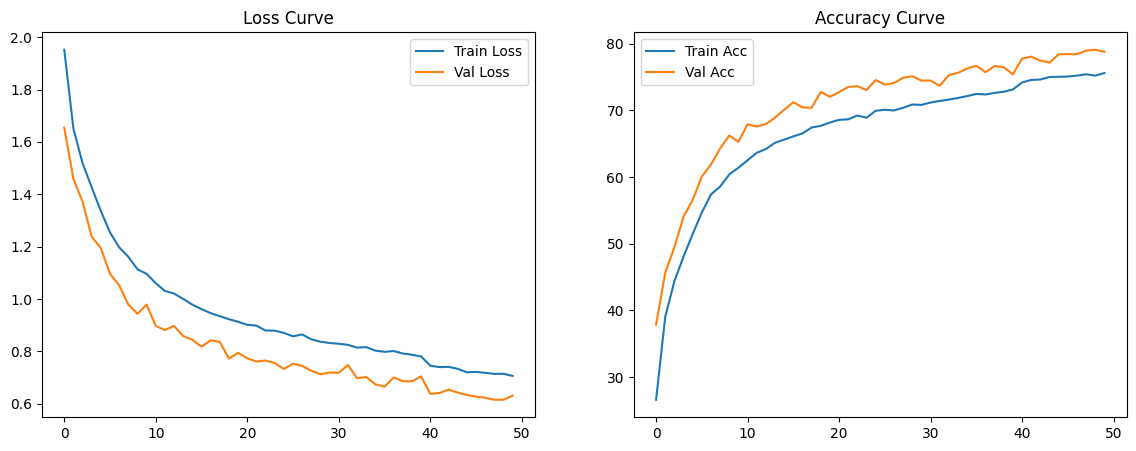

In [31]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title("Accuracy Curve")

plt.show()


In [32]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 79.55%


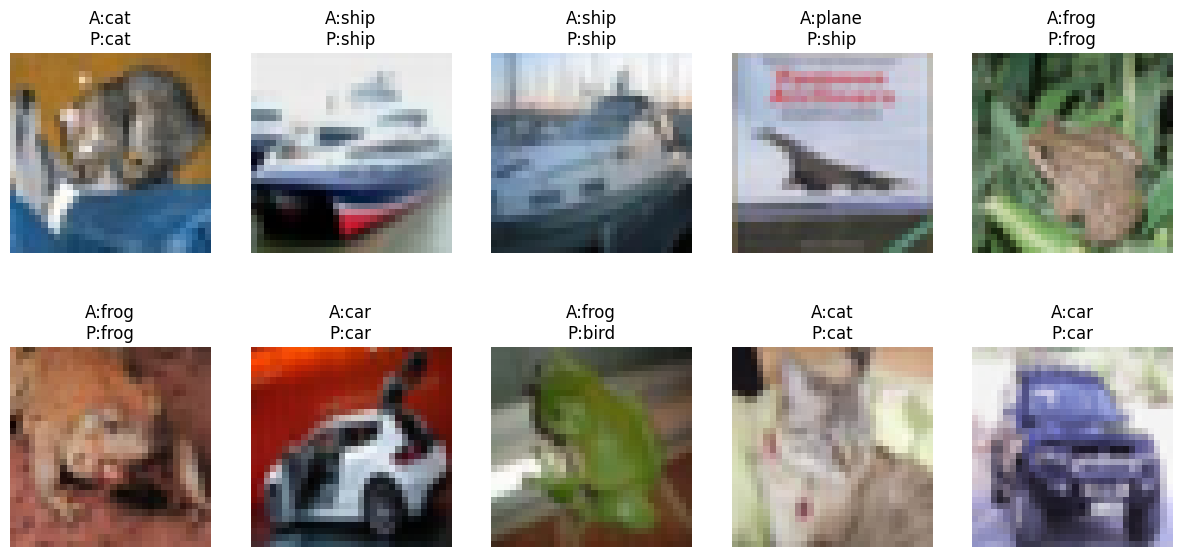

In [55]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

images_gpu = images.to(device)

outputs = model(images_gpu)
_, predicted = outputs.cpu().max(1)

plt.figure(figsize=(15,7))

for i in range(10):
    plt.subplot(2,5,i+1)
    img = images[i] / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.title(f"A:{classes[labels[i]]}\nP:{classes[predicted[i]]}")
    plt.axis('off')

plt.show()


In [35]:
from torch_geometric.data import InMemoryDataset

class GraphDataset(InMemoryDataset):
    def __init__(self, image_dataset, transform=None):
        super(GraphDataset, self).__init__()
        self.image_dataset = image_dataset
        self.transform = transform

        self.data_list = []
        for img, label in self.image_dataset:
            graph = image_to_graph(img)
            graph.y = torch.tensor([label], dtype=torch.long)
            self.data_list.append(graph)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]


In [43]:
graph_train = GraphDataset(train_set)
graph_val = GraphDataset(val_set)
graph_test = GraphDataset(test_dataset)


In [44]:
from torch_geometric.loader import DataLoader as GraphLoader

train_gloader = GraphLoader(graph_train, batch_size=64, shuffle=True)
val_gloader = GraphLoader(graph_val, batch_size=64, shuffle=False)
test_gloader = GraphLoader(graph_test, batch_size=64, shuffle=False)


In [45]:
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm

class GNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Input = 5 features → (R,G,B,X,Y)
        self.conv1 = GCNConv(5, 64)
        self.bn1 = BatchNorm(64)

        self.conv2 = GCNConv(64, 128)
        self.bn2 = BatchNorm(128)

        self.conv3 = GCNConv(128, 128)
        self.bn3 = BatchNorm(128)

        self.fc1 = nn.Linear(128, 128)
        self.drop = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.relu(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = torch.relu(x)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = torch.relu(x)

        x = global_mean_pool(x, batch)

        x = self.fc1(x)
        x = torch.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        return x


In [46]:
model_gnn = GNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_gnn.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)


In [47]:
epochs = 30
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(epochs):
    model_gnn.train()
    train_correct = 0
    total_train = 0
    running_loss = 0

    # TRAIN
    for batch in train_gloader:
        batch = batch.to(device)

        optimizer.zero_grad()
        out = model_gnn(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = out.max(1)
        total_train += batch.y.size(0)
        train_correct += pred.eq(batch.y).sum().item()

    # VALIDATION
    model_gnn.eval()
    val_loss = 0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for batch in val_gloader:
            batch = batch.to(device)
            out = model_gnn(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            val_loss += loss.item()

            _, pred = out.max(1)
            total_val += batch.y.size(0)
            val_correct += pred.eq(batch.y).sum().item()

    avg_train_loss = running_loss / len(train_gloader)
    avg_val_loss = val_loss / len(val_gloader)
    train_acc = 100 * train_correct / total_train
    val_acc = 100 * val_correct / total_val

    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


Epoch [1/30] Train Loss: 2.0082 | Val Loss: 1.9751 Train Acc: 24.06% | Val Acc: 24.76%
Epoch [2/30] Train Loss: 1.8829 | Val Loss: 2.0703 Train Acc: 30.11% | Val Acc: 24.77%
Epoch [3/30] Train Loss: 1.8397 | Val Loss: 2.6738 Train Acc: 32.01% | Val Acc: 17.99%
Epoch [4/30] Train Loss: 1.8249 | Val Loss: 2.8780 Train Acc: 32.81% | Val Acc: 15.84%
Epoch [5/30] Train Loss: 1.8069 | Val Loss: 2.0449 Train Acc: 33.49% | Val Acc: 26.48%
Epoch [6/30] Train Loss: 1.7706 | Val Loss: 1.7801 Train Acc: 35.27% | Val Acc: 34.89%
Epoch [7/30] Train Loss: 1.7616 | Val Loss: 1.7824 Train Acc: 35.69% | Val Acc: 35.52%
Epoch [8/30] Train Loss: 1.7510 | Val Loss: 1.7637 Train Acc: 35.97% | Val Acc: 34.89%
Epoch [9/30] Train Loss: 1.7469 | Val Loss: 1.8737 Train Acc: 36.38% | Val Acc: 32.05%
Epoch [10/30] Train Loss: 1.7353 | Val Loss: 1.8093 Train Acc: 36.76% | Val Acc: 32.80%
Epoch [11/30] Train Loss: 1.7287 | Val Loss: 1.7524 Train Acc: 36.72% | Val Acc: 35.07%
Epoch [12/30] Train Loss: 1.7221 | Val Lo

In [48]:
model_gnn.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in test_gloader:
        batch = batch.to(device)
        out = model_gnn(batch.x, batch.edge_index, batch.batch)
        _, pred = out.max(1)
        total += batch.y.size(0)
        correct += pred.eq(batch.y).sum().item()

print(f"GNN Test Accuracy: {100 * correct / total:.2f}%")


GNN Test Accuracy: 40.59%


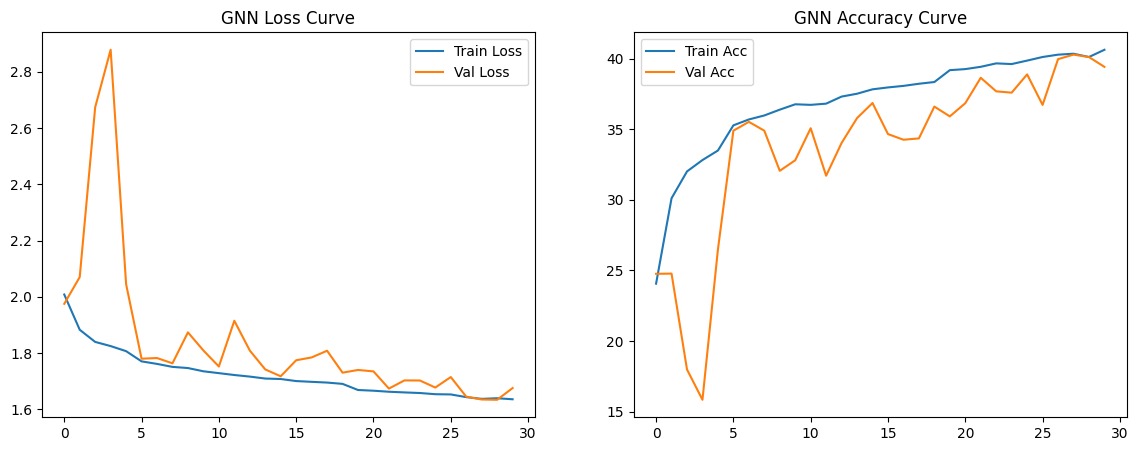

In [49]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Val Loss")
plt.legend()
plt.title("GNN Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_acc_list, label="Train Acc")
plt.plot(val_acc_list, label="Val Acc")
plt.legend()
plt.title("GNN Accuracy Curve")

plt.show()


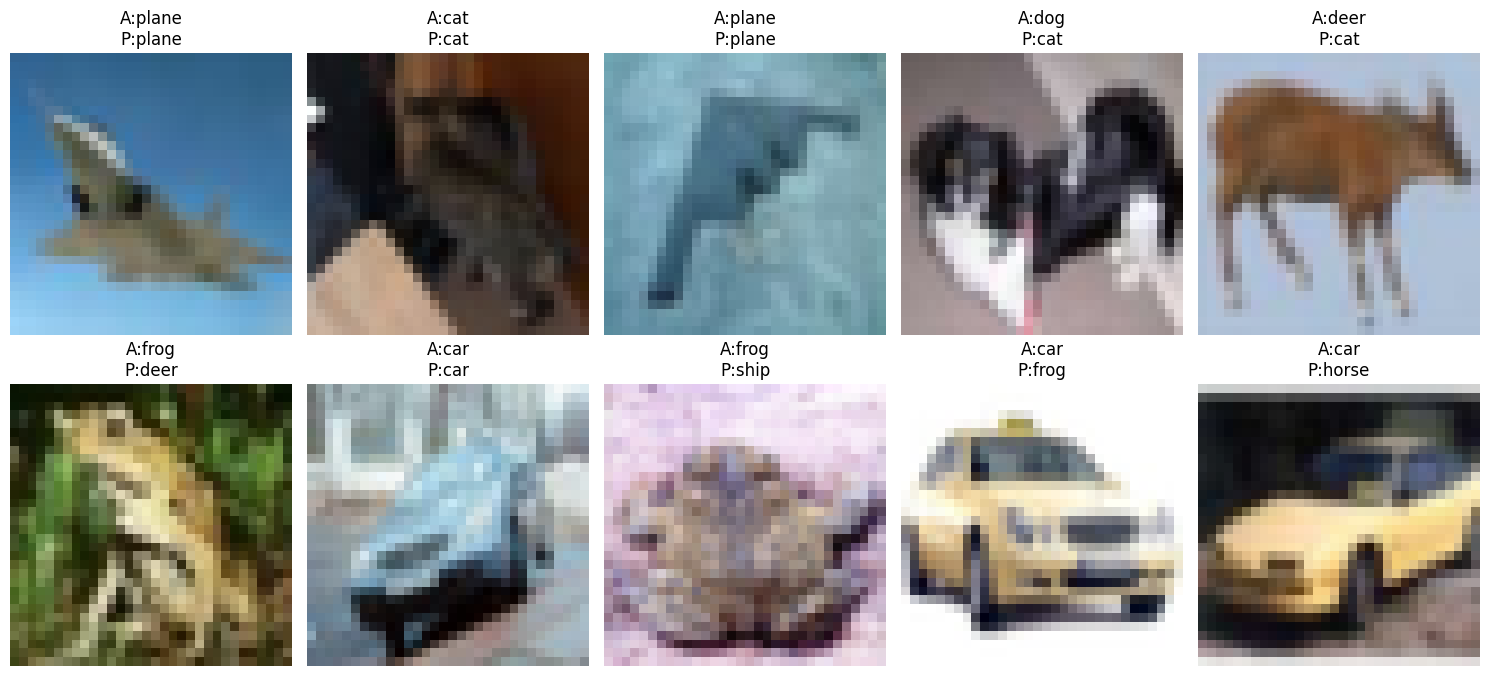

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import random

def unnormalize(img):
    return (img * 0.5 + 0.5).numpy()

model_gnn.eval()

fig = plt.figure(figsize=(15, 7))

# Display 8 images (2 rows x 4 columns)
for i in range(10):
    idx = random.randint(0, len(test_dataset)-1)

    img, label = test_dataset[idx]

    # Build graph for each image
    graph = image_to_graph(img)
    graph.y = torch.tensor([label])
    graph = graph.to(device)

    # Predict
    with torch.no_grad():
        out = model_gnn(graph.x, graph.edge_index,
                        torch.zeros(graph.x.size(0), dtype=torch.long).to(device))
        _, pred = out.max(1)

    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(np.transpose(unnormalize(img), (1, 2, 0)))
    ax.set_title(f"A:{classes[label]}\nP:{classes[pred.item()]}")
    ax.axis("off")

plt.tight_layout()
plt.show()


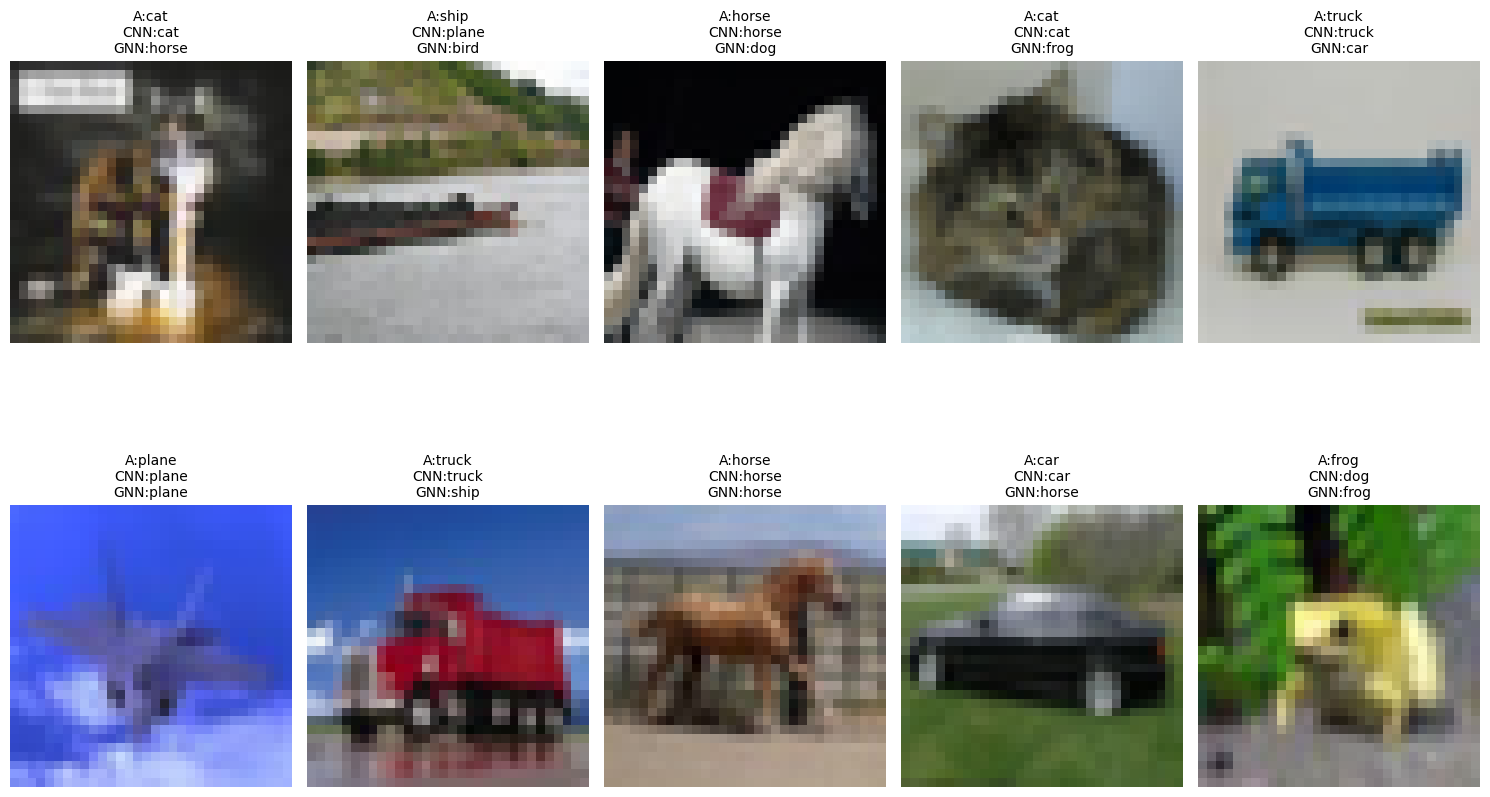

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import random

def unnormalize(img):
    return (img * 0.5 + 0.5).numpy()

model.eval()
model_gnn.eval()

fig = plt.figure(figsize=(15, 10))

for i in range(10):
    idx = random.randint(0, len(test_dataset) - 1)
    img, label = test_dataset[idx]

    # --- CNN PREDICTION ---
    cnn_out = model(img.unsqueeze(0).to(device))
    _, cnn_pred = cnn_out.max(1)
    cnn_pred = cnn_pred.item()

    # --- GNN PREDICTION ---
    graph = image_to_graph(img)
    graph.y = torch.tensor([label])
    graph = graph.to(device)

    with torch.no_grad():
        gnn_out = model_gnn(
            graph.x,
            graph.edge_index,
            torch.zeros(graph.x.size(0), dtype=torch.long).to(device)
        )
        _, gnn_pred = gnn_out.max(1)
        gnn_pred = gnn_pred.item()

    # --- Plot image ---
    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(np.transpose(unnormalize(img), (1, 2, 0)))
    ax.set_title(
        f"A:{classes[label]}\nCNN:{classes[cnn_pred]}\nGNN:{classes[gnn_pred]}",
        fontsize=10
    )
    ax.axis("off")

plt.tight_layout()
plt.show()


CNN Accuracy: 0.7955
CNN Precision: 0.7971809231539033
CNN Recall: 0.7954999999999999
CNN F1 Score: 0.7939720032282434

CNN Classification Report:

              precision    recall  f1-score   support

       plane       0.82      0.80      0.81      1000
         car       0.93      0.89      0.91      1000
        bird       0.74      0.64      0.69      1000
         cat       0.67      0.61      0.64      1000
        deer       0.76      0.78      0.77      1000
         dog       0.72      0.70      0.71      1000
        frog       0.71      0.92      0.80      1000
       horse       0.89      0.79      0.83      1000
        ship       0.87      0.92      0.89      1000
       truck       0.87      0.91      0.89      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.79     10000
weighted avg       0.80      0.80      0.79     10000



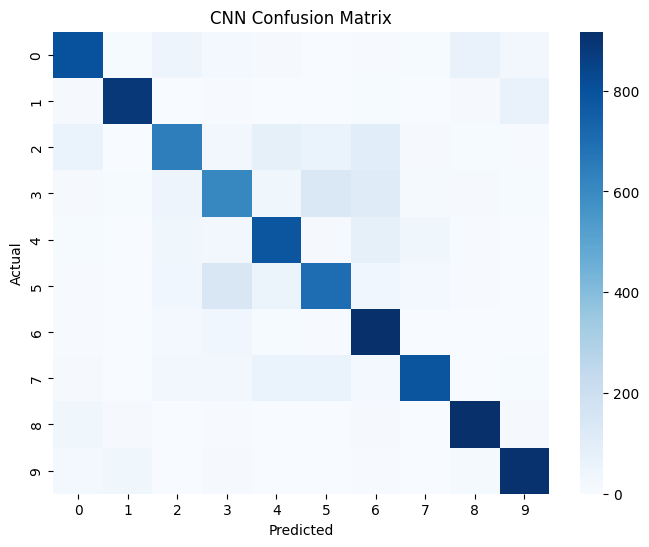

In [57]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Collect predictions and labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Convert to numpy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Accuracy
cnn_accuracy = accuracy_score(all_labels, all_preds)
print("CNN Accuracy:", cnn_accuracy)

# Precision, Recall, F1
prec, rec, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
print("CNN Precision:", prec)
print("CNN Recall:", rec)
print("CNN F1 Score:", f1)

# Full classification report
print("\nCNN Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


GNN Accuracy: 0.4059
GNN Precision: 0.4256435522295227
GNN Recall: 0.4058999999999999
GNN F1 Score: 0.4062580815152523

GNN Classification Report:

              precision    recall  f1-score   support

       plane       0.39      0.65      0.49      1000
         car       0.60      0.41      0.49      1000
        bird       0.27      0.37      0.31      1000
         cat       0.27      0.37      0.31      1000
        deer       0.36      0.22      0.27      1000
         dog       0.37      0.29      0.32      1000
        frog       0.44      0.42      0.43      1000
       horse       0.48      0.41      0.44      1000
        ship       0.56      0.47      0.51      1000
       truck       0.52      0.44      0.48      1000

    accuracy                           0.41     10000
   macro avg       0.43      0.41      0.41     10000
weighted avg       0.43      0.41      0.41     10000



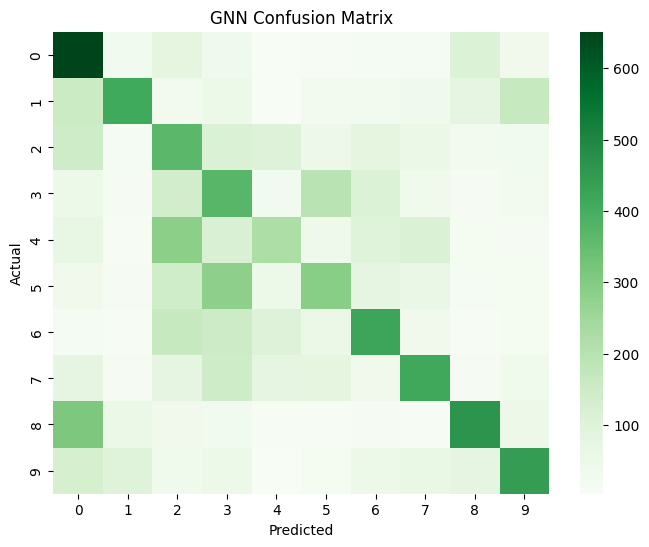

In [58]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

all_preds_gnn = []
all_labels_gnn = []

model_gnn.eval()
with torch.no_grad():
    for batch in test_gloader:
        batch = batch.to(device)
        out = model_gnn(batch.x, batch.edge_index, batch.batch)
        _, preds = out.max(1)

        all_preds_gnn.extend(preds.cpu().numpy())
        all_labels_gnn.extend(batch.y.cpu().numpy())

all_preds_gnn = np.array(all_preds_gnn)
all_labels_gnn = np.array(all_labels_gnn)

# Accuracy
gnn_accuracy = accuracy_score(all_labels_gnn, all_preds_gnn)
print("GNN Accuracy:", gnn_accuracy)

# Precision Recall F1
prec_g, rec_g, f1_g, _ = precision_recall_fscore_support(all_labels_gnn, all_preds_gnn, average='macro')
print("GNN Precision:", prec_g)
print("GNN Recall:", rec_g)
print("GNN F1 Score:", f1_g)

# Full classification report
print("\nGNN Classification Report:\n")
print(classification_report(all_labels_gnn, all_preds_gnn, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(all_labels_gnn, all_preds_gnn)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap="Greens")
plt.title("GNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
